# Sandwich shop
We want to investigate if adding an extra crew member during rush hour is worth our trouble.

#### Some relevant information:
* The arrival time between clients $\left(T\right)$ is a stochastic variable following an exponential distribution with parameter $\lambda(t)$, where $\lambda$ also depends on the time of day. From historical data we know the following about the mean time between client arrivals:
    * from 00:00 until 08:00: shop is closed
    * from 08:00 until 11:00: 25 minutes
    * from 11:00 until 14:00: 1 minutes
    * from 14:00 until 17:00: 10 minutes
    * from 17:00 until 19:00: 2 minutes
    * from 19:00 until 20:00: 5 minutes
    * from 20:00 until 24:00: shop is closed
    
    **Remark: in reality you would execute a measurements campaign and verify if the experimental distribution actually follows an exponential distribution (by means of a Kolmogorov–Smirnov test**
        
* If an employee is available the client places an order (we could also incorporate a decision time). This implies that we need the shop to have a limited `::Resource` i.e. the employees. 

    If no one is available, the client waits for his turn, but has a limited amount of patience. When this runs out, the clients leaves the shop (and should cancel his request for the employee `Resource`). Patience for the different clients is defined as a random variable $\sim\mathcal{U}(5,10)$. 
    * `Resource.level` is the current amount of resources in use
    * `Resource.capacity` is the total amount of resources
    * `Resource.put_queue` are the scheduled processes for the resource and can be used for queue length
* Once the order is placed, the preperation time is also a random variable.

#### Topics:

1. We need to log the activities in our shop:
    1. Queue build-up $\rightarrow$ logging of queue required
    2. Waiting times $\rightarrow$ logging of waiting times required

#### Some food for thought:
* What if we considered clients with a memory? I.e. if they do not get served within their patience range, they go away and spread they word (which in its turn influences future arrival rates).
* Is the extra person worth it from an economic point of view?
* Could you also include orders that are place by phone before a specific time (also requiring the staff's attention)?
*Tto get the authentic shop feeling, we could use the `Dates` package and use actual date and hour for the plots

### Dependencies, Logging setup and supporting functions:
* Plots will be made using the [Plots](http://docs.juliaplots.org/latest/) package. 
* The [Distributions](https://juliastats.github.io/Distributions.jl/stable/) package will be used for distributions and randomness. 
* The [Logging](https://docs.julialang.org/en/v1/stdlib/Logging/index.html) module will be used for efficient debugging and testing during development.
* The [StatsBase](http://juliastats.github.io/StatsBase.jl/latest/index.html) package provides basic support for statistics. We will use it for experimental PDF and CDF in particular.
* The [HypothesisTests]() package contains hypothesis tests that can use to test if our data follows a specific distribution (e.g. normality with a KS-test) or to determine confidence intervals on data (e.g. 95% CI for mean waiting time).



In [3]:
# Dependencies
using Dates              # for actual time & date
using Distributions      # for distributions and random behaviour
using HypothesisTests    # for more statistical analysis
using Logging            # for debugging
using Plots              # for figures
using SimJulia           # for DES
using StatsPlots         # for nicer histograms (cf. solution)
using Statistics         # for statistics

# Available items in the shop
const menulist = ["sandwich, cold","sandwich, hot","pasta","soup"]  # names
const menuprob = Distributions.Categorical([0.6,0.2,0.1,0.1])       # probabilities
const preptimes = Dict( menulist[1]=>Distributions.Uniform(60,90),  # prepatation times
                        menulist[2]=>Distributions.Uniform(60,120), 
                        menulist[3]=>Distributions.Uniform(60,90),
                        menulist[4]=>Distributions.Uniform(30,45))

# Configuring the logger (general)
mylogger = Logging.SimpleLogger(stdout,LogLevel(-10000))
Logging.global_logger(mylogger)
Logging.disable_logging(LogLevel(-4500));

# Explicitly import Base.show in order to use it for our own types
import Base.show

"""
nextarrival(t::DateTime)

Return time between client arrival in milliseconds. 
This implies that milliseconds are the smallest time resolution in our simulation."""
function nextarrival(t::DateTime)
    if (hour(t) >= 8) & (hour(t) < 11)
        d = Distributions.Exponential(25*60000)
    elseif (hour(t) >= 11) & (hour(t) < 14)
        d = Distributions.Exponential(1*60000)
    elseif (hour(t) >= 14) & (hour(t) < 17)
        d = Distributions.Exponential(10*60000)
    elseif (hour(t) >= 17) & (hour(t) < 19)
        d = Distributions.Exponential(2*60000)
    elseif (hour(t) >= 19) & (hour(t) < 20)
        d = Distributions.Exponential(5*60000)
    else
        return nothing
    end
    
    return Millisecond(round(rand(d)))
end;

Some tips:
* You can round a `DateTime` e.g.
```Julia
    round(Dates.now(),Minute)
```
* You can use a `DateTime` within a simulation e.g.
```Julia
    tstart = floor(now(),Day) # start on current day, rounded downwards (why?)
    sim = Simulation(tstart)  # setup simulation starting on tstart
    run(sim, tstart + Day(3)) # run the simulation for three days
```
* The current time of the simulation (as a DateTime) can be obtained with `nowDatetime(sim)`.
* Make a schematical represenation of what is going on and who needs to "communicate" with whom.
* Think about how you will implement all of this (types, field, storage of useful information, opening times etc.)
* You can use a specific logger for a function in order to seperate different information streams e.g.
```Julia
    const globlogger = Logging.SimpleLogger(stdout,LogLevel(-10000)) 
    Logging.global_logger(mylogger)     # set global logger
    io = open("log.txt", "w+")          # select file
    myspecificlogger = SimpleLogger(io) # pair logger with IOStream
    function foo(x...; logger=globlogger)
        with_logger(logger) do
            @info "Total of $(length(x)) arguments:"
            for i in x
                @info("Value of argument: $(i)")
            end
       end 
    end

    foo([1;2;3],"another input","and another",5)
    foo([1;2;3],"another input","and another",5,logger=myspecificlogger)
    close(io)
```


### Arrival process and initial verifications:

In [5]:
@resumable function arrivals(sim::Simulation,topen=8, tclose=20)
    while true
        # before opening hours
        if hour(nowDatetime(sim)) < topen
            delta = floor(nowDatetime(sim),Day) + Hour(topen) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "$(nowDatetime(sim)) - Not open yet, waiting for $(delta)"
            @yield timeout(sim, delta)
        end
        
        # after opening hours
        if hour(nowDatetime(sim)) >= tclose
            delta = floor(nowDatetime(sim),Day) + Day(1) + Hour(topen) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "$(nowDatetime(sim)) - Closing shop, waiting for $(delta)"
            @yield timeout(sim, delta)
        end
        
        # during opening hours
        @logmsg LogLevel(-4600) "Generating - It is now $(nowDatetime(sim))"
        tnext = nextarrival(nowDatetime(sim))
        @yield timeout(sim, tnext)
            
    end
end

arrivals (generic function with 3 methods)

In [6]:
Logging.disable_logging(LogLevel(-4600));
sim = Simulation(floor(Dates.now(),Day))
@process arrivals(sim)
run(sim, floor(Dates.now(),Day) + Day(2))

┌ LogLevel(-4500): 2019-11-05T00:00:00 - Not open yet, waiting for 28800000 milliseconds
└ @ Main In[5]:6
┌ LogLevel(-4500): 2019-11-05T20:03:10.403 - Closing shop, waiting for 43009597 milliseconds
└ @ Main In[5]:13
┌ LogLevel(-4500): 2019-11-06T20:00:31.84 - Closing shop, waiting for 43168160 milliseconds
└ @ Main In[5]:13


### Include store and client behavior & run a single simulation

In [4]:
# define a shop
struct Shop
    staff::Resource
    queuelength::Array{Tuple{DateTime,Int64},1}
    clients::Dict
    waitingtimes::Array
    renegtimes::Array{DateTime,1}
    function Shop(sim::Simulation,nstaff::Int=1)
        staff = Resource(sim,nstaff)         # add the crew
        queuelength = [(nowDatetime(sim),0)] # add simulation initialisation time
        clients = Dict()                     # keep record of each client
        waitingtimes = []                    # store all waiting times
        renegtimes = Array{DateTime,1}()     # store reneg moments
        return new(staff,queuelength,clients,waitingtimes,renegtimes)
    end
end

function show(io::IO,s::Shop)
    print(io,"Shop with $(s.staff.capacity) employees, currently $(length(s.staff.put_queue)) people waiting")
end

# define a client
mutable struct Client
    id::Int
    patience::Second
    orderhist::Dict
    proc::Process
    function Client(sim::Simulation,shop::Shop)
        client = new()
        client.id = length(shop.clients) + 1
        client.patience = Second(round(rand(Distributions.Uniform(5*60,10*60))) )
        client.orderhist = Dict()
        # add client to shop registry
        shop.clients[client.id]= client
        # start the client process
        client.proc = @process clientbehavior(sim,shop,client)
        return client
    end
end
    
function show(io::IO,c::Client)
    print(io,"Client N° $(c.id) with $(round(c.patience.value / 60,digits=2)) minutes of patience")
end

show (generic function with 435 methods)

In [5]:
@resumable function arrivals(sim::Simulation,shop::Shop,topen=8, tclose=20)
    while true
        # before opening hours => wait
        if hour(nowDatetime(sim)) < topen
            delta = floor(nowDatetime(sim),Day) + Hour(topen) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "$(nowDatetime(sim)) - Not open yet, waiting for $(delta)"
            @yield timeout(sim, delta)
        end
        
        # after opening hours => wait
        if hour(nowDatetime(sim)) >= tclose
            delta = floor(nowDatetime(sim),Day) + Day(1) + Hour(topen) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "$(nowDatetime(sim)) - Closing shop, waiting for $(delta)"
            @yield timeout(sim, delta)
        end
        
        # during opening hours => generate clients
        tnext = nextarrival(nowDatetime(sim))
        @yield timeout(sim, tnext)
        c = Client(sim,shop)
    end
end

@resumable function clientbehavior(sim::Simulation, shop::Shop, client::Client)
    @logmsg LogLevel(-4000) "Client (N° $(client.id) arrives on $(nowDatetime(sim))) (Client patience: $(client.patience))"
    @yield timeout(sim, Second(round(rand(Distributions.Uniform(10,30)))))  # choose what to get
    choice = menulist[rand(menuprob)]
    tin = nowDatetime(sim)                               # Logging of arrival time
    req = request(shop.staff)                            # try to obtain a staff member to make my sandwich
    res  = @yield req | timeout(sim, client.patience)
    push!(shop.queuelength,(nowDatetime(sim),length(shop.staff.put_queue))) # log of current queuelength
    
    if res[req].state == SimJulia.processed
        @logmsg LogLevel(-4000) "Client (N° $(client.id) is being served on $(nowDatetime(sim))) and orders: $(choice)"
        tserved = nowDatetime(sim)
        twait = tserved - tin # in milliseconds
        push!(shop.waitingtimes,twait)
        @yield timeout(sim,Second(round(rand(preptimes[choice])))) # preparing order
        @logmsg LogLevel(-4000) "Client (N° $(client.id) receives order on $(nowDatetime(sim)))"
        @yield release(shop.staff) # releasing
    else
        @logmsg LogLevel(-4000) "Client (N° $(client.id) ran out of patience on $(nowDatetime(sim)))"
        cancel(shop.staff,req)                   # cancel staff request
        push!(shop.renegtimes,nowDatetime(sim))  # store renegtimes
    end 
end



clientbehavior (generic function with 1 method)

In [6]:
Logging.disable_logging(LogLevel(-3200));
sim = Simulation(floor(Dates.now(),Day))
s = Shop(sim,1)
@process arrivals(sim, s)
run(sim, floor(Dates.now(),Day) + Hour(22))

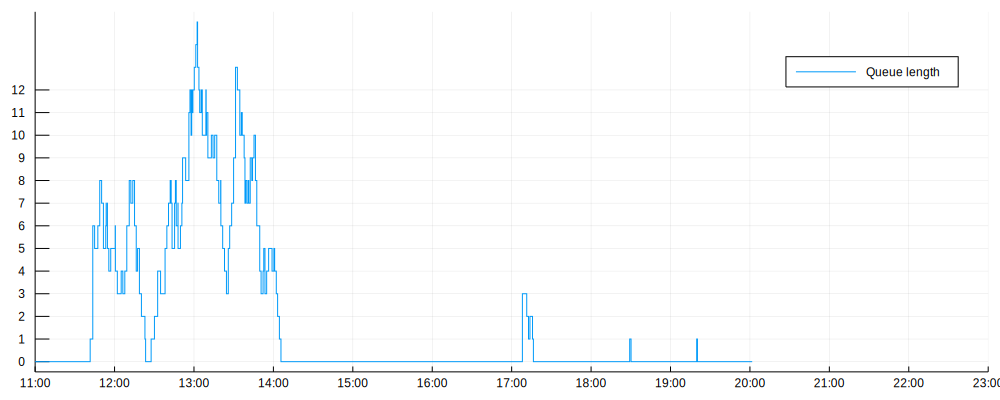

In [7]:
ind = findall(x->x≠0,map(x -> hour(x[1]) > 10 & hour(x[1]) <= 15 ? x[1] : 0, s.queuelength))
v = s.queuelength#[ind]
x = map(x->x[1], v)
y = map(x->x[2], v)
p = plot(size=(1000,400),x,y,linetype=:steppost, label="Queue length")
# some makeup
tstart = floor(Dates.now(),Day)+Hour(11)
tstop = floor(Dates.now(),Day)+Hour(23)
daterange =  tstart : Minute(60) : tstop
datexticks = [Dates.value(mom) for mom in daterange]
datexticklabels = Dates.format.(daterange,"HH:MM")#Dates.format.(daterange, "HH:MM")

xticks!(datexticks, datexticklabels,rotation=0)
xlims!(Dates.value(tstart),Dates.value(tstop))
yticks!(0:1:12)

## Analyze trends with several simulations

In [8]:
function shopsim(nsim=100,staffing=1,tstart=floor(now(),Day) + Hour(7) + Minute(30), tstop=floor(now(),Day) + Hour(20) + Minute(30))
    Nreneg = Int64[]
    MWT = Float64[]
    MQL = Float64[]
    for i in 1:nsim
        sim = Simulation(tstart)
        shop = Shop(sim,staffing)
        @process arrivals(sim,shop)
        run(sim,tstop)
        push!(Nreneg,length(shop.renegtimes))
        push!(MWT,mean(Dates.value.(shop.waitingtimes)/1e3))
        push!(MQL,mean([x[2] for x in shop.queuelength]))
    end
    return Nreneg,MWT,MQL
end

shopsim (generic function with 5 methods)

In [9]:
# create some data
Logging.disable_logging(LogLevel(-3000))
(Nreneg, MWT, MQL) = shopsim(1000,1);

In [12]:
s = std(MWT)

25.395221413871372

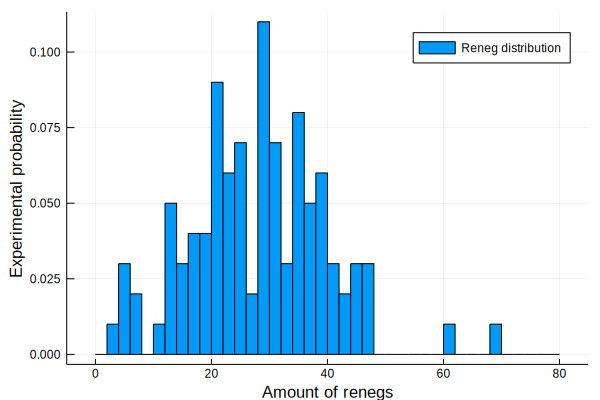

In [10]:
StatsPlots.histogram(Nreneg,bins=0:2:80,normalize=:probability, label="Reneg distribution")
xlabel!("Amount of renegs")
ylabel!("Experimental probability")

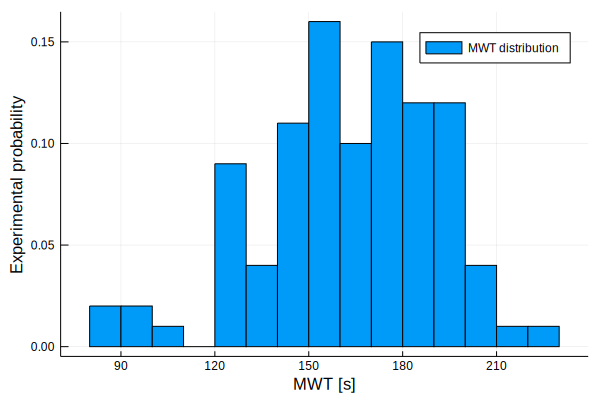

In [11]:
StatsPlots.histogram(MWT,bins=20,normalize=:probability, label="MWT distribution")
xlabel!("MWT [s]")
ylabel!("Experimental probability")

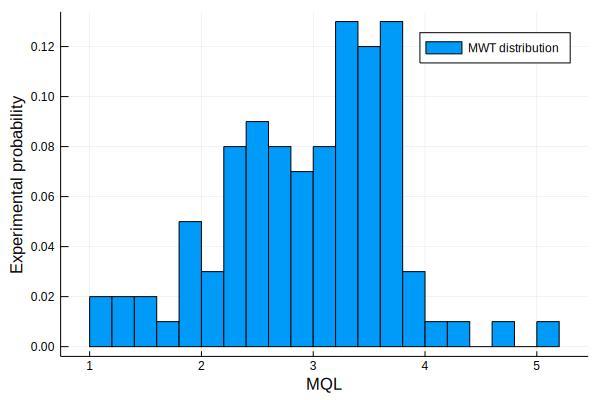

In [12]:
StatsPlots.histogram(MQL,bins=20,normalize=:probability, label="MWT distribution")
xlabel!("MQL")
ylabel!("Experimental probability")

In [13]:
### Determine when you have enough samples and verify "stability"
# create some data
r = []
for i in 1:4
    Logging.disable_logging(LogLevel(-3000))
    (Nreneg, MWT, MQL) = shopsim(10^i,1);
    push!(r, MWT)
end

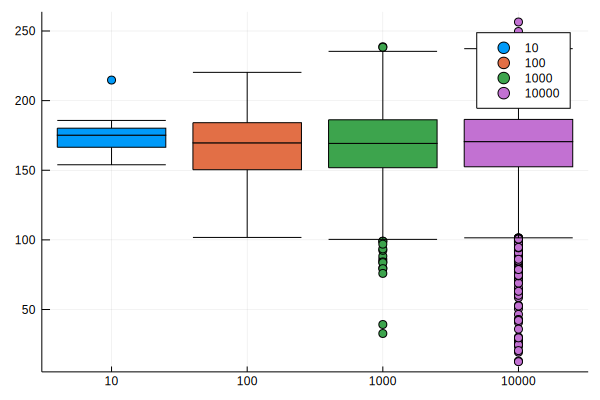

In [14]:
boxplot(r, label=["10"; "100"; "1000";"10000"])
xticks!([1;2;3;4],["10"; "100"; "1000";"10000"])

In [15]:
ExactOneSampleKSTest(MWT,Normal(mean(MWT),std(MWT)))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.03512840317807053

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-10

Details:
    number of observations:   10000


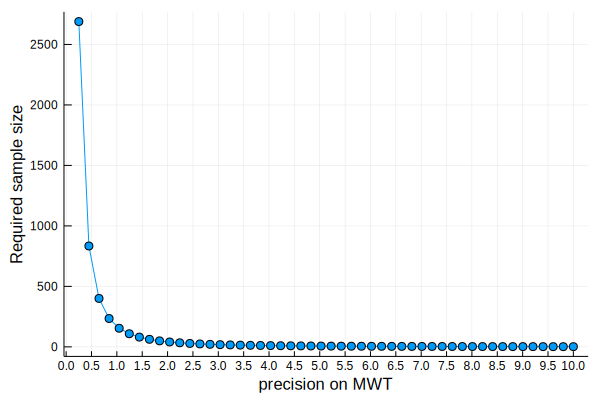

In [20]:
E = range(0.25, stop=10, length=50)
n = (std(MWT)*quantile(Normal(),1 - 0.05/2) ./ E ) .^2 #HYP: normal distribution
plot(E,n,marker=:circle,label="")
xlabel!("precision on MWT")
ylabel!("Required sample size")
xticks!(0:0.5:10)
#yticks!(0:1000:8000)

In [15]:
# create some data
Logging.disable_logging(LogLevel(-3000))
(Nreneg, MWT, MQL) = shopsim(1000,2);

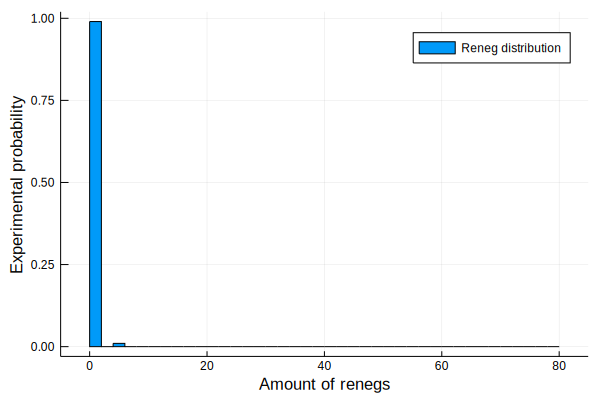

In [19]:
StatsPlots.histogram(Nreneg,bins=0:2:80,normalize=:probability, label="Reneg distribution")
xlabel!("Amount of renegs")
ylabel!("Experimental probability")

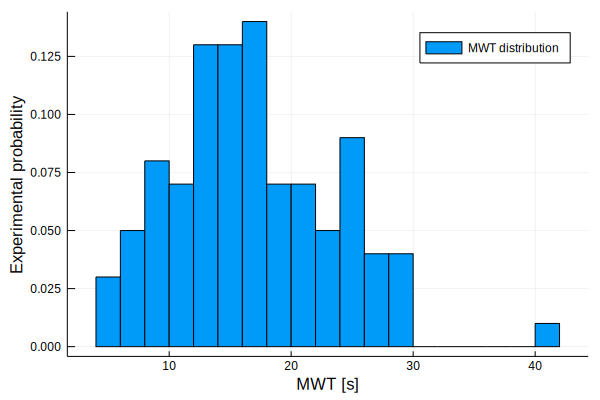

In [20]:
StatsPlots.histogram(MWT,bins=20,normalize=:probability, label="MWT distribution")
xlabel!("MWT [s]")
ylabel!("Experimental probability")

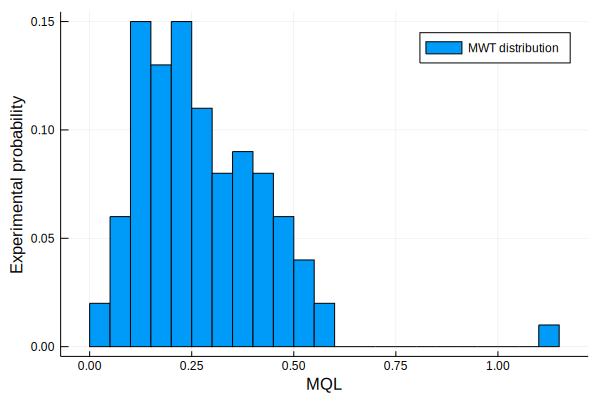

In [21]:
StatsPlots.histogram(MQL,bins=20,normalize=:probability, label="MWT distribution")
xlabel!("MQL")
ylabel!("Experimental probability")

## Parameter study
Add the variable staffing aspect an look at its impact on the waiting times, renegs etc.

In [22]:
"""
function staffer(sim::Simulation,shop::Shop,npeak::Int)

Extra function that monitors time and updates staffing accordingly.
"""

@resumable function staffer(sim::Simulation,shop::Shop,npeak::Int)
    nnorm = shop.staff.capacity
    while true
        @yield timeout(sim,Minute(5))
        if (hour(nowDatetime(sim)) >= 11) & (hour(nowDatetime(sim)) < 14)
            if shop.staff.capacity != nnorm + npeak
                shop.staff.capacity = nnorm + npeak
                @logmsg LogLevel(-2000) "Scaling up to $(shop.staff.capacity) on time $(nowDatetime(sim)) "
            end
        else
            if shop.staff.capacity != nnorm
                shop.staff.capacity = nnorm
                @logmsg LogLevel(-2000) "Scaling down to $(shop.staff.capacity) on time $(nowDatetime(sim)) "
            end
        end
    end
end

staffer (generic function with 1 method)